<a href="https://colab.research.google.com/github/Martinmbiro/Pytorch-computer-vision-basics/blob/main/04%20Implementing%20TinyVGG%20model%20architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing [`TinyVGG`](https://www.youtube.com/watch?v=HnWIHWFbuUQ)**
> In this notebook, I'll be buiding a modified version of `TinyVGG` CNN architecture described in the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/) as well as the YouTube video linked [`here`](https://www.youtube.com/watch?v=HnWIHWFbuUQ)


> 📝 **Note**  
+ All the steps we followed in the previous notebook remain the same, except the neural network I'll be using here

In [ ]:
# imports
import torch, torchvision, matplotlib.pyplot as plt, torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset

# print torch version
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [ ]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

# print device
device

'cpu'

### Load the data
> Let's get the data ready
+ I'll re-create the function that returns [`DataLoaders`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for training and testing data from the [`FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) dataset

In [ ]:
def load_data():
  """A function that returns train_set and test_set DataLoaders
  Returns
  ---
  train_dl
    DataLoader wrapped around the training data
  test_dl
    DataLoader wrapped arond the test data
  """
  # batch size
  BATCH_SIZE = 32

  # train data
  train_data = datasets.FashionMNIST(
      root='data', train=True, download=True, transform=ToTensor())
  # testing data
  test_data = datasets.FashionMNIST(
      root='data', train=False, download=True, transform=ToTensor())

  # train_loader
  train_dl = DataLoader(
      dataset=train_data, shuffle=True, batch_size=BATCH_SIZE)
  # test_laoder
  test_dl = DataLoader(
      dataset=test_data, shuffle=False, batch_size=BATCH_SIZE)

  return train_dl, test_dl

In [ ]:
# get DataLoaders
train_dl, test_dl = load_data()

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.79MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



#### Visualizing random batch
> Here, I'll take a random batch from the training `DataLoader` and visualize it
+ We'll first convert the training `DataLoader` into a list and use a random index to access a random batch

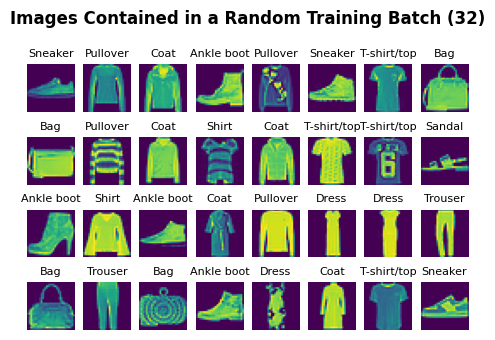

In [ ]:
# generate random index
idx = np.random.randint(low=0, high=len(train_dl))
# get random batch
batch_x, batch_y = list(train_dl)[idx] # convert batch to list

# specify figure and subplots
f, axs = plt.subplots(4, 8, # 4*8 = 32
            figsize=(4.5, 4.5), layout='compressed')
for i, ax in enumerate(axs.flat):
  img, lb = batch_x[i], batch_y[i]
  ax.set_title(train_dl.dataset.classes[lb], fontsize=8)
  ax.axis(False); ax.imshow(img.squeeze())

f.suptitle('Images Contained in a Random Training Batch (32)',
             weight='black',
             y=0.9) #suptitle position
plt.show()

### Build the `TinyVGG` architecture
> Basically, the original `TinyVGG` network consists of two _convolutional_ blocks and a _classifier_ block
+ Each _convolutional_ block consists of two [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) with `10` `out_channels`, two [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) activations for non-linearity and a [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) layer
+ The _classifier_ block consists of one [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) and a [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) for classification


> 📝 **Note**

> I'll be making a few modification on the original `TinyVGG` architecture as follows:
+ The number of `out_channels` begins at `64` for the first `nn.Conv2d` layer and doubles for each subsequent `nn.Conv2d` layer
+ An [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) layer after each `nn.Conv2d` layer, but before the `nn.ReLU` non-linear activation
+ An [`nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d) layer after the `nn.Flatten` and first `nn.Linear` layer in the `classifier` block
+ An [`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) layer just before the output layer of the `classifier` block
+ Also, we'll use [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as optimizer and [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss) as loss function, since this is a multi-class classification problem


In [ ]:
def get_model(device):
  """A function that returns a model, optimizer and loss function
  Returns
  ---
  model: torch.nn.Module
    A TinyVGG architecture model

  opt: torch.Optimizer
    An optimizer

  loss_fn: torch.nn.Module
    A loss function for multi-class classification
  """
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  # define model
  class TinyVGG(nn.Module):
    def __init__(self):
      super().__init__()
      # conv_block1
      self.conv_b1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          #nn.Dropout(p=0.15),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2))

      # conv_block2
      self.conv_b2 = nn.Sequential(
          nn.Conv2d(128, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 512, 3, padding=1),
          nn.BatchNorm2d(512),
          # nn.Dropout(p=0.15),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2))

      # classifier
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.BatchNorm1d(25088),
          nn.Linear(in_features=25088, out_features=256),
          nn.BatchNorm1d(256),
          nn.Dropout(p=0.05), # droput regularization
          nn.Linear(256, 10))

    def forward(self, x):
      return self.classifier(self.conv_b2(self.conv_b1(x)))

  # get an object of the model
  model = TinyVGG().to(device)

  # optimizer
  '''opt = torch.optim.Adam(params=model.parameters(),
                         lr=0.0009) # learning rate'''
  # optimizer
  opt = torch.optim.SGD(
      params=model.parameters(),
      lr=0.0001,  # learning rate
      momentum=0.5) #

  # loss_function
  loss_fn = nn.CrossEntropyLoss()

  return model, opt, loss_fn

In [ ]:
# get model, optimizer, loss function
model, opt, loss_fn = get_model()

#### Visualize structure of neural network
> We'll do this using the [`torchinfo`](https://github.com/TylerYep/torchinfo) library

In [ ]:
# install torchinfo
!pip install torchinfo
from torchinfo import summary

In [ ]:
# view model structure
summary(model=model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           128
│    └─ReLU: 2-3                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 128, 28, 28]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 28, 28]          256
│    └─ReLU: 2-6                         [1, 128, 28, 28]          --
│    └─MaxPool2d: 2-7                    [1, 128, 14, 14]          --
├─Sequential: 1-2                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-8                       [1, 256, 14, 14]          295,168
│    └─BatchNorm2d: 2-9                  [1, 256, 14, 14]          512
│    └─ReLU: 2-10                        [1, 256, 14, 14]          --
│ 

### Early stopping
> 💎 **Pro Tip**

> [Early stopping](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.) is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, we'll create a class to take care of _early-stopping_

In [ ]:
# define a class for early stopping
from copy import deepcopy

class EarlyStopping:
  '''
    patience -> the number of epochs to wait after the last improvement
                before stopping

    counter -> how many epochs have passed since the last improvement

    min_delta -> how much of a difference in loss is to be considered
          worthy to continue training
  '''
  def __init__(self, score_type:str, min_delta:float=0.0, patience:int=5):
    self.counter = 0
    self.patience = patience
    self.min_delta = min_delta
    self.score_type = score_type
    self.best_epoch = None
    self.best_score = None
    self.best_state_dict = None
    self.stop_early = False

    if (self.score_type != 'metric') and (self.score_type != 'loss'):
      err_msg = 'score_type can only be "metric" or "loss"'
      raise Exception(err_msg)

  def __call__(self, model:nn.Module, ep:int, ts_score:float):
    if self.best_epoch is None: # for first time:
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best loss
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())

    # if previous loss - current loss exceeds min_delta: (for loss function)
    elif (self.best_score - ts_score >= self.min_delta) and (self.score_type == 'loss'):
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    # if current metric - previous. metric exceeds min_delta: (for metric)
    elif (ts_score - self.best_score >= self.min_delta) and (self.score_type == 'metric'):
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    else: # otherwise
      self.counter += 1 # increment counter each time
      if self.counter >= self.patience:
        self.stop_early = True

In [ ]:
# initialize early stopping class
est = EarlyStopping(score_type='loss', patience=3)

### Model training
> First, I'll define functions for training and testing batches, then I'll run an optimization loop

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# function for model training
def train_batches(model:nn.Module, train_dl:torch.utils.data.DataLoader,
                optimizer:torch.optim.Optimizer, device):
  """Trains model on all batches of train-set DataLoader and returns average training loss, accuracy and f1_score

  Returns
  ---
  ls: float
    average training loss across all batches of data
  acc: float
    average training accuracy across all batches of data
  f1: float
    average training f1_score across all batches of data
  """
  # function to train batches of data
  # for reproducability
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)

  ls, f1, acc = 0, 0, 0
  # training-mode
  model.train()
  # loop through each batch in the training DataLoader
  for x, y in train_dl:
    x = x.to(device); y = y.to(device)
    # optimizer zero-grad
    optimizer.zero_grad()
    # forward pass
    logits = model(x)
    y_pred = F.softmax(logits, dim=1).argmax(dim=1).cpu().numpy()
    # accumulate accuracy_score
    acc += accuracy_score(
        y_true=y.cpu().numpy(), # tensor -> numpy
        y_pred=y_pred)

    # accumulate f1_score
    f1 += f1_score(
        y_true=y.cpu().numpy(), # tensor -> numpy
        y_pred=y_pred, average='macro')

    # loss
    loss = loss_fn(logits, y)
    ls += loss.item() # accumulate loss

    # back propagation
    loss.backward()
    # gradient descent
    optimizer.step()

  # average the values
  ls /= len(train_dl)
  f1 /= len(train_dl)
  acc /= len(train_dl)

  return ls, acc, f1

# function to test batches of data
def test_batches(model:nn.Module, test_dl:torch.utils.data.DataLoader,
                device):
  """Evaluates model on all batches of test-set DataLoader and returns average test loss, accuracy and f1_score

  Returns
  ---
  ls: float
      average test loss across all batches of data
  acc: float
      average test accuracy across all batches of data
  f1: float
      average test f1_score across all batches of data
  """
  ls, f1, acc = 0, 0, 0
  # evaluation-mode
  model.eval()

  with torch.inference_mode():
    # loop through each batch in testing DataLoader
    for x, y in test_dl:
      x = x.to(device); y = y.to(device)
      # forward pass
      logits = model(x)
      y_pred = F.softmax(logits, dim=1).argmax(dim=1).cpu().numpy()

      # loss
      ls += loss_fn(logits, y).item()

      # accumulate accuracy
      acc += accuracy_score(
          y_true=y.cpu().numpy(), # tensor -> numpy
          y_pred=y_pred)

      # accumulate f1_score
      f1 += f1_score(
          y_true=y.cpu().numpy(), # tensor -> numpy
          y_pred=y_pred, average='macro')

  # average the values
  ls /= len(test_dl)
  f1 /= len(test_dl)
  acc /= len(test_dl)

  return ls, acc, f1

# a function that returns prediction labels and prediction probabilities
def get_preds_proba(model:torch.nn.Module, test_dl:torch.utils.data.DataLoader):
  """A function that returns y_pred and y_proba from the passed DataLoader

  Parameters
  ---

  model: torch.nn.Module
    A neural network that subclasses torch.nn.Module

  test_dl: torch.utils.data.DataLoader
    A DataLoader for the test dataset

  Returns
  ---
  y_pred:np.ndarray
    A numpy ndarray with prediction labels

  y_proba: np.ndarray
    A numpy ndarray with prediction probabilities
  """
  # get predictions, pred-proba, and convert to numpy array
  with torch.inference_mode():
    pred_list, proba_list = [], []

    model.eval()
    for x, _ in test_dl: # append all prediction tensors into a list
      logits = model.to(device)(x.to(device))

      proba_list.append(F.softmax(logits, dim=1)) # probabilities
      pred_list.append(F.softmax(logits, dim=1).argmax(dim=1)) # predictions

    y_pred = torch.concatenate(pred_list).cpu().numpy()
    y_proba = torch.concatenate(proba_list).cpu().numpy()

  # confirm shape of y_proba and y_pred
  # return y_pred, y_proba
  return y_pred, y_proba

In [ ]:
%%time
# lists to keep progress of training values
train_loss, test_loss, train_f1, test_f1, train_acc, test_acc, ep_list = [],\
    [], [], [], [], [], [],
# epochs
epochs = 40

# optimization loop
for ep in range(1, epochs+1):
  ep_list.append(ep)
  # train
  tr_loss, tr_acc, tr_f1 = train_batches(model, train_dl, opt, device)
  # append the train values returned to respective lists
  train_loss.append(tr_loss), train_acc.append(tr_acc), train_f1.append(tr_f1)

  # test
  ts_loss, ts_acc, ts_f1 = test_batches(model, test_dl, device)
  # append the train values returned to respective lists
  test_loss.append(ts_loss), test_acc.append(ts_acc), test_f1.append(ts_f1)

  # early stopping
  est(model=model, ep=ep, ts_score=ts_loss)
  if est.stop_early:
    break

  # if ep%2 == 0:
  print(f'Epoch: {ep}\n----------')
  print(f'Train Loss: {tr_loss:.3f} | Test Loss: {ts_loss:.3f}')
  print(f'Train Accuracy: {tr_acc:.3f} | Test Accuracy: {ts_acc:.3f}')
  print(f'Train F1-Score: {tr_f1:.3f} | Test F1-Score: {ts_f1:.3f}\n')

# print best results
print(f'STOPPED | Best Epoch: {est.best_epoch} | Best Loss: {est.best_score:.3f}')

Epoch: 1
----------
Train Loss: 0.500 | Test Loss: 0.378
Train Accuracy: 0.839 | Test Accuracy: 0.873
Train F1-Score: 0.808 | Test F1-Score: 0.847

Epoch: 2
----------
Train Loss: 0.336 | Test Loss: 0.329
Train Accuracy: 0.891 | Test Accuracy: 0.888
Train F1-Score: 0.866 | Test F1-Score: 0.865

Epoch: 3
----------
Train Loss: 0.287 | Test Loss: 0.304
Train Accuracy: 0.908 | Test Accuracy: 0.898
Train F1-Score: 0.886 | Test F1-Score: 0.876

Epoch: 4
----------
Train Loss: 0.254 | Test Loss: 0.288
Train Accuracy: 0.920 | Test Accuracy: 0.902
Train F1-Score: 0.900 | Test F1-Score: 0.882

Epoch: 5
----------
Train Loss: 0.228 | Test Loss: 0.277
Train Accuracy: 0.930 | Test Accuracy: 0.905
Train F1-Score: 0.912 | Test F1-Score: 0.885

Epoch: 6
----------
Train Loss: 0.207 | Test Loss: 0.268
Train Accuracy: 0.939 | Test Accuracy: 0.908
Train F1-Score: 0.922 | Test F1-Score: 0.888

Epoch: 7
----------
Train Loss: 0.187 | Test Loss: 0.262
Train Accuracy: 0.946 | Test Accuracy: 0.911
Train F1-S

In [ ]:
# overwrite the model parameters with best parameters
model.load_state_dict(est.best_state_dict)

<All keys matched successfully>

In [ ]:
# get prediction labels and probabilities
y_pred, y_proba = get_preds_proba(model, test_dl)

# confirm the size of both
y_pred.shape, y_proba.shape

((10000,), (10000, 10))

### Model evaluation
> Here, I'll evaluate the model by plotting results from the optimization loop, as well as evaluating it on basis of classification metrics  

> ✋ **Info**
+ I'll be using [`scikit-learn`](https://scikit-learn.org/stable/index.html) [classification metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#classification-metrics)

#### Define custom evaluation functions
> Here, I'll define functions to
+ Plot results from optimization loop
+ Plot confusion matrix

In [ ]:
# function to plot train and test results
def plot_train_results(ep_list:list, train_score:list, test_score:list,
                       ylabel, title:str, best_epoch:None):
  """A function that plots train and test results against each other
  """
  f, ax = plt.subplots(figsize=(5, 3), layout='constrained')

  # train loss
  ax.plot(ep_list, train_score, label='Training',
          linewidth=1.7, color='#0047ab')

  # test loss
  ax.plot(ep_list, test_score, label='Validation',
          linewidth=1.7, color='#990000')
  # vertical line (for early stopping)
  if best_epoch is not None:
    ax.axvline(best_epoch, linestyle='--', color='#000000', linewidth=1.0,
             label=f'Best ep ({best_epoch})')

  # axis, title
  ax.set_title(title, weight='black')
  ax.set_ylabel(ylabel)
  ax.set_xlabel('Epoch')
  ax.tick_params(axis='both', labelsize=9)
  plt.grid(color='#e5e4e2')

  # legend
  f.legend(fontsize=9, loc='upper right',
          bbox_to_anchor=(1.28, 0.93),
          fancybox=False)

  plt.show()

In [ ]:
# function to plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray):
  # define figure and plot
  _, ax = plt.subplots(figsize=(4.0,4.0), layout='compressed')
  # plot
  ConfusionMatrixDisplay.from_predictions(
      y_true=y_true,
      y_pred=y_pred, cmap='Blues', colorbar=False, ax=ax)

  # for x and y labels
  ax.set_ylabel('True Labels', weight='black')
  ax.set_xlabel('Predicted Labels', weight='black',
                  color='#dc143c')
  # tick size and position
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')
  ax.tick_params(axis='both', labelsize=9)

  # change annotation font
  for txt in ax.texts:
    txt.set_fontsize(9)

  plt.show()

#### Plot optimization results

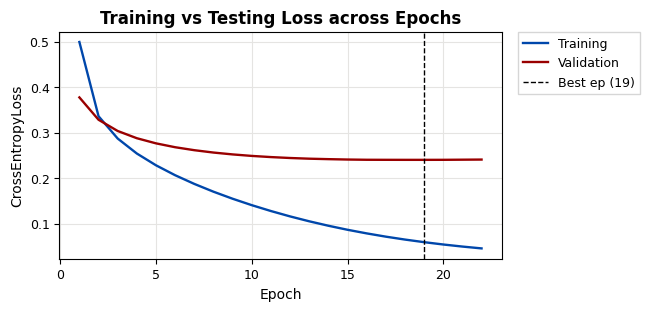

In [ ]:
# training vs testing loss
plot_train_results(ep_list=ep_list, train_score=train_loss, test_score=test_loss,
                   ylabel='CrossEntropyLoss',
                   title='Training vs Testing Loss across Epochs',
                   best_epoch=est.best_epoch)

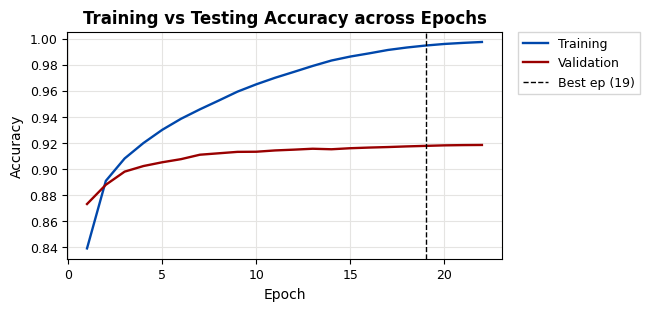

In [ ]:
# training vs testing accuracy
plot_train_results(ep_list=ep_list, train_score=train_acc, test_score=test_acc,
                   ylabel='Accuracy',
                   title='Training vs Testing Accuracy across Epochs',
                   best_epoch=est.best_epoch)

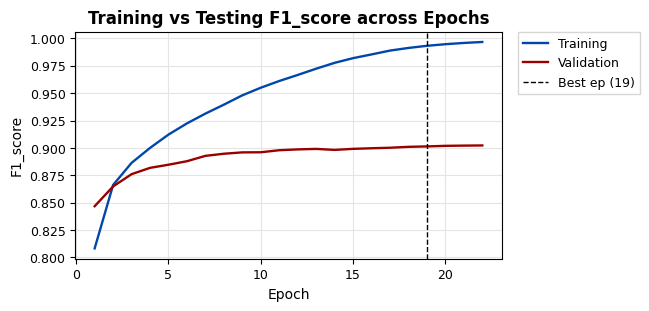

In [ ]:
# training vs testing f1_scores
plot_train_results(ep_list=ep_list, train_score=train_f1, test_score=test_f1,
                   ylabel='F1_score',
                   title='Training vs Testing F1_score across Epochs',
                   best_epoch=est.best_epoch)

#### [`accuracy`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [ ]:
# compute accuracy
acc = accuracy_score(
    y_true=test_dl.dataset.targets.cpu().numpy(), #tensor->numpy
    y_pred=y_pred)
# print
print(f'Model Accuracy: {acc:.4f}')

Model Accuracy: 0.9179


#### [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

In [ ]:
# compute f1_score
f1 = f1_score(y_true=test_dl.dataset.targets.cpu().numpy(), #tensor->numpy
                     y_pred=y_pred, average='macro')
# print
print(f'F1_score: {f1:.4f}')

F1_score: 0.9181


#### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(y_true=test_dl.dataset.targets.cpu().numpy(), #tensor->numpy
                     y_pred=y_pred)
# print
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1000
           1       1.00      0.97      0.99      1000
           2       0.88      0.87      0.87      1000
           3       0.91      0.92      0.91      1000
           4       0.87      0.86      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.76      0.77      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



#### [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [ ]:
from sklearn.metrics import roc_auc_score
# calculate
ras = roc_auc_score(y_true=test_dl.dataset.targets.cpu().numpy(),
                    y_score=y_proba,
                    multi_class='ovr')
# print
print(f'roc_auc_score: {ras:.3f}')

roc_auc_score: 0.995


#### [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

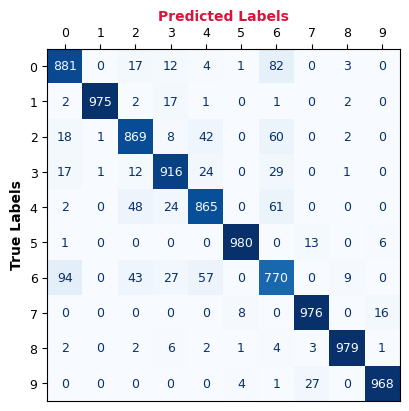

In [ ]:
# plot confusion matrix
plot_confusion_matrix(
    y_true=test_dl.dataset.targets.cpu().numpy(),
    y_pred=y_pred)

In [ ]:
# check the classes again:
test_dl.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Save model
> 🔔 **Info**

> Pytorch's recommended way of saving a model is by saving its [`state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict). To do this, the [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended) recommends calling [`torch.save(obj=model.state_dict(), f=PATH)`](https://pytorch.org/docs/stable/generated/torch.save.html#torch-save)
+ `f` - a file-like object or a string or `os.PathLike` object containing a file name. To work with paths, we'll use Python's [`pathlib`](https://docs.python.org/3/library/pathlib.html) module
+ A common PyTorch convention is to save models using either a `.pt` or `.pth` file extension
+ Also, it's good practice to move the model to the `cpu` before saving its `state_dict`

In [ ]:
from pathlib import Path

# parent directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# model path
MODEL_PATH = PARENT/'tiny_vgg.pth'
print(MODEL_PATH)

models/tiny_vgg.pth


In [ ]:
# save the model's state_dict
torch.save(obj=model.cpu().state_dict(), f=MODEL_PATH)
print(f"MODEL'S state_dict SAVED TO: {MODEL_PATH}")

MODEL'S state_dict SAVED TO: models/tiny_vgg.pth


#### Load saved model
> To load a previously saved model's `state_dict`, we call
 [`torch.load(f=PATH, weights_only=True)`](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load) that loads an object saved using [`torch.save()`](https://pytorch.org/docs/stable/generated/torch.save.html#torch-save) from a file:

```
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(PATH, weights_only=True))
    model.eval()
```

> 🔔 **Info**
+ Remember that you must call `model.eval()` before running inference
+ `f` - a file-like object or a string or `os.PathLike` object containing a file name. To work with paths, we'll use Python's [`pathlib`](https://docs.python.org/3/library/pathlib.html) module
+ Note that a `model` class must have been defined earlier, before calling [`model.load_state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.load_state_dict) on the object

In [ ]:
# first create an object of model class
loaded_model, _, _ = get_model(device)

# overwrite state_dict
loaded_model.load_state_dict(
    torch.load(f=MODEL_PATH, weights_only=True))

<All keys matched successfully>

### Make inference
> First, I'll declare functions to make inference
+ On a single random data point
+ On multiple random data points

In [ ]:
# function to make inference on a single random image
def make_single_inference(model:torch.nn.Module, dataset:torch.utils.data.Dataset,
                          device:str):
  """
  Makes inference using a random data point from the test dataset

  Parameter
  ---
  model : torch.nn.Module
      A model (subclassing torch.nn.Module) to make inference

  device : str
      cpu, cuda, mps
  """
  # get random image from test_set
  idx = np.random.choice(len(dataset))
  img, lb = dataset[idx]

  # make prediction
  with torch.inference_mode():
    model.to(device) # move model to device
    model.eval() # set eval mode
    lgts = model.to(device)(img.unsqueeze(0).to(device))
    pred = F.softmax(lgts, dim=1).argmax(dim=1)

  # print actual retrieved image
  plt.figure(figsize=(1.0, 1.0))
  # title with label
  if pred==lb:
    plt.title(
        f'Actual: {dataset.classes[lb]}\nPred: {dataset.classes[pred]}',
        fontsize=8)
  else: # if labels do not match, title = with red colour
    plt.title(
        f'Actual: {dataset.classes[lb]}\nPred: {dataset.classes[pred]}',
        fontsize=8, color='#de3163', weight='black')
  plt.axis(False)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.show()

In [ ]:
# function to make inference on multiple random images
def make_multiple_inference(model:torch.nn.Module, dataset:torch.utils.data.Dataset,
                            device:str):
  """
  Makes inference using 12 random data points from the test dataset

  Parameter
  ---
  model : torch.nn.Module
      A model (subclassing torch.nn.Module) to make inference

  device : str
      cpu, cuda, mps
  """
  # get array of 12 random indices of images in test_dataset
  indices = np.random.choice(len(dataset),
                                  size= 12, replace=False)
  # create subset from the 12 indices
  sub_set = Subset(dataset=dataset, indices=indices)

  # define a figure and subplots
  f, axs = plt.subplots(2, 6, figsize=(6,5), layout='compressed')

  # move model to device & set eval mode
  model.to(device)
  model.eval()

  # loop through each subplot
  for i, ax in enumerate(axs.flat):
    img, lb = sub_set[i] # return image and label

    # make inference on image retuned
    with torch.inference_mode():
      lg = model(img.unsqueeze(0).to(device))
      pred = F.softmax(lg, dim=1).argmax(dim=1)

    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis(False)
    if pred==lb:
      ax.set_title(
          f'Actual: {test_dl.dataset.classes[lb]}\nPred: {dataset.classes[pred]}',
          fontsize=8)
    else: # if labels do not match, title = with red colour
      ax.set_title(
          f'Actual: {dataset.classes[lb]}\nPred: {dataset.classes[pred]}',
          fontsize=8, color='#de3163', weight='black')

  f.suptitle('Inference Made on 12 Random Test Images',
            weight='black',
            y=0.83)
  plt.show()

#### Make inference using single image
> Here, I'll use the loaded model to make inference on a single random image from the _testing set_


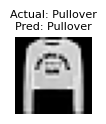

In [ ]:
make_single_inference(loaded_model, test_dl.dataset, device)

#### Making inference using multiple images
> ✋ **Info**  
> The function we defined implements the following steps:
+ Using [`numpy.random.choice`](), we'll retrieve 12 random indices of samples from the test dataset
+ Then, we'll create a [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) using these indices
+ We'll define a `figure` and `subplots` using [`matplotlib.pyplot.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
+ We'll loop through each `subplot`
+ For each `subplot`, we'll retrieve an image from the `sub_set`, perform inference on it, and print the actual vs predicted class on the plot

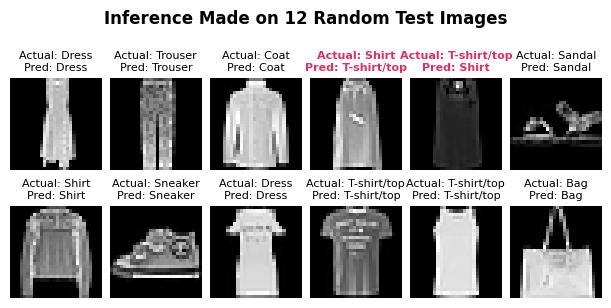

In [ ]:
make_multiple_inference(loaded_model, test_dl.dataset, device)

### Conclusion

> 📈 **Results**  

> Based on the overall classification metrics, the model we've trained in this notebook - a tweaked version of [`TinyVGG`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), performs much better than the neural network built using [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) activations in the previous notebook.



> Notably however, from the `classification_report` and `confusion_matrix`, the model still struggles for classes `0` (`T-shirt/top`), `4` (`Coat`) and `6` (`Shirt`), probably due to the inherent ambiguity between these classes in the dataset

> We were able to achieve the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.92`
+ An overall model accuracy of `0.9179`
+ An overall `roc_auc_score` of `0.995`

> Compared to the neural network built in the previous notebook, where we achieved the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.91`
+ An overall model accuracy of `0.9099`
+ An overall `roc_auc_score` of `0.994`

> 🌱 **Future improvements**
+ In future, I might want to think of including redundant helper functions / classes in a python script and import them when needed. This will help clean up the notebook significantly
+ Until then, happy coding 👋